## Libraries

In [1]:
import os
import sys
import wandb

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

import torch
torch.cuda.empty_cache()

import torch.nn as nn
#from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import RobertaConfig, RobertaModel, get_linear_schedule_with_warmup, AdamW

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from typing import Sequence
from functools import partial
from collections import Counter

print(torch.__version__)
print(transformers.__version__)
print(torch.cuda.is_available())


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


1.13.1+cu117
4.30.2
True


In [2]:
seed = 56
workers = True
os.environ["PL_GLOBAL_SEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ["PL_SEED_WORKERS"] = f"{int(workers)}"

## Split Data

In [3]:
dict_item_to_author = pd.read_csv('./data/item_authors.csv')
print(dict_item_to_author['author_title'].nunique())
dict_item_to_author = dict(zip(dict_item_to_author['item_id'], dict_item_to_author['author_title']))

179428


In [4]:
np.asarray(list(dict_item_to_author.values())).max()

179427

In [5]:
start_history = []
train_items = set()

with open('./data/train') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        videos = line.strip().split(' ')
        videos = list(map(int, videos))
        start_history.append(videos)
        train_items.update(videos)
start_history_lengths = np.asarray([len(x) for x in start_history])
bin_thresholds = np.quantile(start_history_lengths, q=[np.arange(0.1, 1.0, 0.1)])
start_history_bins = np.digitize(start_history_lengths, bins=bin_thresholds.flatten())

  0%|          | 0/1393055 [00:00<?, ?it/s]

In [6]:
np.sum(start_history_lengths)

27757278

In [7]:
bin_thresholds

array([[ 7.,  8.,  9., 10., 12., 14., 17., 23., 38.]])

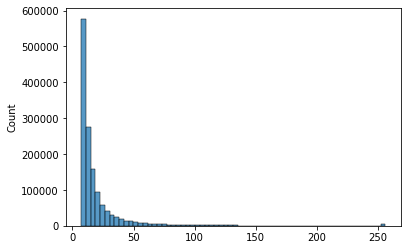

In [8]:
sns.histplot(start_history_lengths, bins=64)
plt.show()

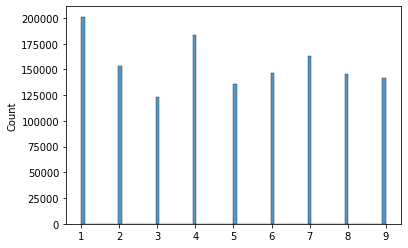

In [9]:
sns.histplot(start_history_bins)
plt.show()

In [10]:
start_history_bins

array([6, 1, 8, ..., 1, 4, 2])

In [11]:
train_start_history, val_start_history = train_test_split(start_history, test_size=0.2, random_state=56, stratify=start_history_bins)

In [12]:
len(train_start_history), len(val_start_history)

(1114444, 278611)

In [13]:
train_start_history_lengths = np.asarray([len(x) for x in train_start_history])
train_bin_thresholds = np.quantile(train_start_history_lengths, q=[np.arange(0.1, 1.0, 0.1)])
train_start_history_bins = np.digitize(train_start_history_lengths, bins=train_bin_thresholds.flatten())

val_start_history_lengths = np.asarray([len(x) for x in val_start_history])
val_bin_thresholds = np.quantile(val_start_history_lengths, q=[np.arange(0.1, 1.0, 0.1)])
val_start_history_bins = np.digitize(val_start_history_lengths, bins=val_bin_thresholds.flatten())

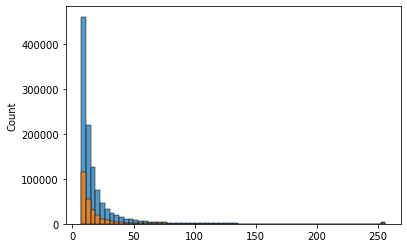

In [14]:
sns.histplot(train_start_history_lengths, bins=64)
sns.histplot(val_start_history_lengths, bins=64)
plt.show()

In [15]:
class ItemEncoder:
    def __init__(self, keep_top_n):
        self.keep_top_n = keep_top_n
        self.item_to_id = None
        self.id_to_item = None
        self.counter = Counter()
        self.is_locked = False
        
    def fit(self, data):
        if self.is_locked:
            raise Exception("encoder has been locked")
        self.counter.update(data)
        
    def transform(self, data):
        if not self.is_locked:
            raise Exception("transforming with unlocked encoder is not allowed")
        return np.vectorize(lambda x: self.item_to_id.get(x, 0))(data) # unk key is 0
    
    def inverse_transform(self, data):
        if not self.is_locked:
            raise Exception("transforming with unlocked encoder is not allowed")
        return np.vectorize(self.id_to_item.__getitem__)(data)
    
    def lock(self):
        self.id_to_item = [-1] + list(map(lambda x: x[0], self.counter.most_common(self.keep_top_n)))
        self.item_to_id = {x: i for i, x in enumerate(self.id_to_item)}
        assert len(self.id_to_item) == len(self.item_to_id)
        self.is_locked = True
    
    def __len__(self):
        return len(self.id_to_item)        

In [16]:
item_encoder = ItemEncoder(keep_top_n=None)
for seq in train_start_history:
    item_encoder.fit(seq)
item_encoder.lock()

In [17]:
author_encoder = ItemEncoder(keep_top_n=None)
for seq in train_start_history:
    author_encoder.fit(map(lambda x: dict_item_to_author[x], seq))
author_encoder.lock()

In [18]:
len(item_encoder), len(train_items)

(1021298, 1167029)

In [19]:
# val_start_history = [seq for seq in val_start_history if set(seq).issubset(train_items)]

In [20]:
item_encoder.counter.most_common(10)

[(144691, 327703),
 (302657, 313071),
 (1594159, 295979),
 (1761620, 263484),
 (68646, 237070),
 (170129, 227356),
 (836422, 201378),
 (1508623, 179780),
 (803844, 146045),
 (902590, 143146)]

In [21]:
val_true = []
most_common_item = item_encoder.counter.most_common(1)[0][0]
for i, _ in tqdm(enumerate(val_start_history)):
    answer = val_start_history[i][-1]
    val_true += [answer]
    val_start_history[i][-1] = most_common_item # magic number for sanity check 

0it [00:00, ?it/s]

## Create dataset

In [22]:
class SpecialTokens:
    def __init__(self, tokens):
        assert len(tokens) == len(set(tokens))
        assert 'pad_token' in tokens
        assert 'mask_token' in tokens
        self.n_tokens = len(tokens)
        for i, x in enumerate(tokens):
            setattr(self, x, i)
    
    def __len__(self):
        return self.n_tokens

In [23]:
def list2d_to_np(list2d, pad_token=-1):
    np_list2d = np.ones(
        [len(list2d), len(max(list2d, key=lambda x: len(x)))], dtype=int
    ) * pad_token
    for i, j in enumerate(list2d):
        np_list2d[i][0:len(j)] = j
    return np_list2d

In [24]:
class YaCupDataset(Dataset):
    def __init__(
        self,
        data,
        item_encoder,
        author_encoder,
        item_to_author_dict,
        special_tokens: Sequence[str],
        mask_prob: float,
        force_last_token_mask_prob: float,
        max_len: int
    ):
        self.special_tokens = SpecialTokens(special_tokens)
        self.vocab_size = len(item_encoder) + len(self.special_tokens)
        self.author_size = len(author_encoder) + 1 # 0 is masked author
        self.mask_prob = mask_prob
        self.force_last_token_mask_prob = force_last_token_mask_prob
        self.max_len = max_len
        self.item_encoder = item_encoder
        self.author_encoder = author_encoder
        self.item_to_author_dict = item_to_author_dict
        self.data, self.data_lengths, self.data_authors = YaCupDataset._preprocess_list_2d(
            data,
            token_shift=len(self.special_tokens),
            pad_token=self.special_tokens.pad_token,
            item_encoder=self.item_encoder,
            author_encoder=self.author_encoder,
            item_to_author_dict = self.item_to_author_dict,
            author_shift = 1, # masked tokens are special 
        )
        
    def __getitem__(self, index):
        return self._preprocess_sequence(self.data[index], self.data_lengths[index], self.data_authors[index])
        
    def __len__(self):
        return len(self.data)
        
    @staticmethod
    def _preprocess_list_2d(list2d, token_shift, pad_token, item_encoder, author_encoder, item_to_author_dict, author_shift):
        np_list2d = np.ones(
            [len(list2d), len(max(list2d, key=lambda x: len(x)))], dtype=int
        ) * pad_token
        np_lengths = np.zeros(len(list2d), dtype=int)
        np_list2d_authors = np.zeros(
            [len(list2d), len(max(list2d, key=lambda x: len(x)))], dtype=int
        )
        for i, j in enumerate(list2d):
            np_list2d[i][0:len(j)] = item_encoder.transform(j)[::-1]  # reverse for better pos encoding learning
            np_list2d[i][0:len(j)] += token_shift
            np_lengths[i] = len(j)
            # transform items to authors, encode authors with author_encoder, reverse the order just start above
            np_list2d_authors[i][0:len(j)] = author_encoder.transform(
                list(map(lambda x: item_to_author_dict[x], j))
            )[::-1]
            np_list2d_authors[i][0:len(j)] += author_shift
        return np_list2d, np_lengths, np_list2d_authors
    
    def _preprocess_sequence(self, sequence_ids, length, author_ids):
        input_ids = torch.LongTensor(sequence_ids).clone()
        labels = torch.LongTensor(sequence_ids).clone()
            
        if np.random.random() < self.force_last_token_mask_prob:
            mask = torch.zeros(sequence_ids.shape)
            mask[0] = True
        else:
            mask = torch.rand(sequence_ids.shape)
            mask = (mask < self.mask_prob)
        mask *= (input_ids > len(self.special_tokens)) # don't mask special tokens
        if mask.sum() == 0:
            mask = torch.zeros(sequence_ids.shape)
            mask[0] = True
            mask *= (input_ids > len(self.special_tokens)) # don't mask special tokens
        mask_indices = mask.nonzero().flatten()
        n_masked = torch.LongTensor([len(mask_indices)])
        input_ids[mask_indices] = self.special_tokens.mask_token
        attention_mask = (input_ids != self.special_tokens.pad_token) * 1.0
        token_type_ids = torch.LongTensor(author_ids).clone()
        token_type_ids[mask_indices] = 0 # masked segment
        author_labels = torch.LongTensor(author_ids).clone()
        
        author_labels[token_type_ids != 0] = -100 # calculate loss only for masked tokens
        author_labels[length:] = -100 # remove pad tokens from loss
        labels[input_ids != self.special_tokens.mask_token] = -100 # calculate loss only for masked tokens
        # labels[input_ids == self.special_tokens.pad_token] = -100 # calculate loss only for non-pad tokens
        inputs = {
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'author_labels': author_labels,
            'n_masked': n_masked,
            'last_token_index': torch.LongTensor([length - 1]),
        }
        
        return inputs

In [25]:
dataset = YaCupDataset(
    train_start_history,
    item_encoder=item_encoder,
    author_encoder=author_encoder,
    item_to_author_dict=dict_item_to_author,
    special_tokens=['cls_token', 'sep_token', 'mask_token', 'pad_token'],
    mask_prob=0.2,
    force_last_token_mask_prob=0.0,
    max_len=256,
)

val_dataset = YaCupDataset(
    val_start_history,
    item_encoder=item_encoder,
    author_encoder=author_encoder,
    item_to_author_dict=dict_item_to_author,
    special_tokens=['cls_token', 'sep_token', 'mask_token', 'pad_token'],
    mask_prob=0.2,
    force_last_token_mask_prob=1.0,
    max_len=256,
)

In [26]:
dataloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=24,
    drop_last=True,
    shuffle=True,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=24,
    drop_last=False,
    shuffle=False,
    pin_memory=True
)

In [27]:
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import MaskedLMOutput
from torch.nn import CrossEntropyLoss


class YacupModel(nn.Module):
    def __init__(self, config, label_smoothing):
        super().__init__()
        self.config = config
        self.bert = RobertaModel(config)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        
        self.label_smoothing = label_smoothing
        
    def init_weights(self):
        self.bert.init_weights()
                
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        filter_history_items: Optional[bool] = False,
        loss_class_weight: Optional[torch.Tensor] = None,
        trim_length: Optional[int] = None,
        item_to_author_mapper: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], MaskedLMOutput]:
        """Mostly from https://github.com/huggingface/transformers/blob/v4.23.1/src/transformers/models/bert/modeling_bert.py#L1288"""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        trim_length = trim_length if trim_length is not None else self.config.max_position_embeddings
        
        if item_to_author_mapper is None:
            raise Exception("item_to_author_mapper must be passed")
        
        outputs = self.bert(
            input_ids[:, :trim_length],
            attention_mask=attention_mask[:, :trim_length],
            token_type_ids=token_type_ids[:, :trim_length],
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        # sum of item and author embeddings
        output_embedding_matrix = self.bert.embeddings.word_embeddings.weight + self.bert.embeddings.token_type_embeddings.weight[item_to_author_mapper] # torch.index_select(self.bert.embeddings.token_type_embeddings.weight, dim=0, index=item_to_author_mapper)
        prediction_scores = (sequence_output @ output_embedding_matrix.T) + self.bias
        if filter_history_items:
            prediction_scores.scatter_(dim=2, index=input_ids.unsqueeze(1), src=-10000 * torch.ones_like(input_ids.unsqueeze(1),dtype=prediction_scores.dtype))
        masked_lm_loss = None
        if labels is not None:
            # for some reason CrossEntropyLoss raises out of bounds exception when executed with `reduction = 'mean'` (default) when `label_smoothing != 0` and `weight is not None`
            # hence, to dodge this issue we init CrossEntropyLoss with `reduction='none'` and later we average the numbers
            if self.label_smoothing != 0.0:
                loss_fct = CrossEntropyLoss(weight=loss_class_weight, label_smoothing=self.label_smoothing, reduction='none')
                masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels[:, :trim_length].flatten()).mean()
            else:
                loss_fct = CrossEntropyLoss(weight=loss_class_weight, label_smoothing=self.label_smoothing)
                masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels[:, :trim_length].flatten())

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=prediction_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [28]:
model_config = RobertaConfig(
    vocab_size=dataset.vocab_size,
    hidden_size=512,
    max_position_embeddings=256,
    attention_probs_dropout_prob=0.0,
    hidden_act='gelu',
    hidden_dropout_prob=0.0,
    initializer_range=0.02,
    intermediate_size=1024,
    num_attention_heads=4,
    num_hidden_layers=2,
    type_vocab_size=dataset.author_size,
)

model = YacupModel(
    model_config,
    label_smoothing=0.0
)
model.init_weights()

In [29]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
YacupModel                                                   1,021,302
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   522,906,624
│    │    └─Embedding: 3-2                                   131,072
│    │    └─Embedding: 3-3                                   45,438,976
│    │    └─LayerNorm: 3-4                                   1,024
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  4,205,568
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      262,656
│    │    └─Tanh: 3-8                                        --
Total params: 573,967,222
Trainable params: 573,967,222

In [30]:
def calc_mrr(predict, answer):
    for i in range(len(predict)):
        if predict[i] == answer:
            return 1. / (i + 1)
    return 0

max_prediction_len = 10

def calc_score(y_true, y_pred):
    mrr_score = 0
    for (pred, answer) in tqdm(zip(y_pred, y_true)):
        if len(pred) > max_prediction_len:
            raise ValueError('$maximum prediction length is {}, got {}$'.format(max_prediction_len, len(y_pred[i])))
        mrr_score += calc_mrr(pred, answer)

    print("MRR@10 = {}".format(mrr_score / len(y_true)))
    return mrr_score / len(y_true)

In [31]:
# crutch: put loops in scope to avoid memory fragmentaion

def train(model, dl, DEVICE, TRIM_LENGTH):
    item_to_author_indices_nn = torch.LongTensor(list(dict_item_to_author_nn.get(item_id, 1) for item_id in range(dataset.vocab_size))).to(DEVICE, non_blocking=True)
    loss_class_weight = torch.ones(dataset.vocab_size)
    loss_class_weight[:len(dataset.special_tokens) + 1] = 0.0 # we don't care about a special token loss or an unk token loss
    loss_class_weight = loss_class_weight.to(DEVICE, non_blocking=True)

    tbar = tqdm(dl, file=sys.stdout)
    loss_sum = 0.0
    n_masked_sum = 0
    model.train()
    for idx, batch in enumerate(tbar):
        with torch.cuda.amp.autocast():
            res = model.forward(
                input_ids=batch['input_ids'].to(DEVICE, non_blocking=True),
                attention_mask=batch['attention_mask'].to(DEVICE, non_blocking=True),
                token_type_ids=batch['token_type_ids'].to(DEVICE, non_blocking=True),
                labels=batch['labels'].to(DEVICE, non_blocking=True),
                filter_history_items=True,
                loss_class_weight=loss_class_weight,
                trim_length=TRIM_LENGTH,
                item_to_author_mapper=item_to_author_indices_nn
            )
            batch_masked_sum = batch['n_masked'].to(DEVICE, non_blocking=True).sum()
            loss = res.loss # / batch_masked_sum; normalization hurts performance
        scaler.scale(loss).backward()

        if (idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
        loss_sum += res.loss.detach().item()
        n_masked_sum += batch_masked_sum.detach().item()
        tbar.set_postfix_str(f"Epoch {e + 1} Loss: {loss_sum / n_masked_sum} lr: {optimizer.param_groups[0]['lr']:.5}")
        
        if idx % 100 == 0:
            wandb.log({"loss": loss_sum / n_masked_sum})

def validate(model, dl, DEVICE, TRIM_LENGTH):
    item_to_author_indices_nn = torch.LongTensor(list(dict_item_to_author_nn.get(item_id, 1) for item_id in range(dataset.vocab_size))).to(DEVICE, non_blocking=True)
    
    model.eval()
    all_preds = []
    for batch in tqdm(dl):
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                batch_input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
                res = model.forward(
                    input_ids=batch_input_ids,
                    attention_mask=batch['attention_mask'].to(DEVICE, non_blocking=True),
                    token_type_ids=batch['token_type_ids'].to(DEVICE, non_blocking=True),
                    labels=batch['labels'].to(DEVICE, non_blocking=True),
                    filter_history_items=True,
                    trim_length=TRIM_LENGTH,
                    item_to_author_mapper=item_to_author_indices_nn
                )

                scores = res.logits[:, 0, :].unsqueeze(1) # predict last item
                scores[:, :, :len(dataset.special_tokens) + 1] = -10000 # +1 due to unk token
                # remove historical items form predictions; allow only new items
                # scores.scatter_(dim=2, index=batch_input_ids.unsqueeze(1), src=-10000 * torch.ones_start(batch_input_ids.unsqueeze(1),dtype=scores.dtype))
                scores = scores.squeeze(1)
                preds = torch.topk(scores, k=10, dim=1).indices - len(dataset.special_tokens)
                all_preds += preds.detach().cpu().numpy().tolist()

    all_preds = item_encoder.inverse_transform(all_preds)
    return all_preds 

In [32]:
def load_from_checkpoint(checkpoint_name, model, optimizer, new_lr=None):
    checkpoint = torch.load(checkpoint_name)
    model.load_state_dict(checkpoint['model'])
    if new_lr is not None:
        for param_groups in checkpoint['optimizer']['param_groups']:
            param_groups['lr'] = new_lr
            param_groups['initial_lr'] = new_lr
    optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
DEVICE = 'cuda'
model.to(DEVICE)
TRIM_LENGTH = 64
best_val_score = -10000.0

checkpoint_name = None

# +1 is a shift for masked_author token
dict_item_to_author_nn = {item_encoder.transform(k).tolist() + len(dataset.special_tokens) :author_encoder.transform(v).tolist() + 1 for k, v in tqdm(dict_item_to_author.items())}
# 1 is an unknown author token
# item_to_author_indices_nn = torch.LongTensor(list(dict_item_to_author_nn.get(item_id, 1) for item_id in range(dataset.vocab_size))).to(DEVICE)

epochs=20
accumulation_steps=100
learning_rate = 2.5e-4
num_train_optimization_steps = int(epochs * len(dataloader) / accumulation_steps)
correct_bias = True
weight_decay = 1e-05
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters, lr=learning_rate, correct_bias=correct_bias, 
)

if checkpoint_name is not None:
    load_from_checkpoint(checkpoint_name, model, optimizer, new_lr=learning_rate)

warmup_steps = int(1 * len(dataloader) / accumulation_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=num_train_optimization_steps
)
scaler = torch.cuda.amp.GradScaler()
run = wandb.init(project='Rutube', config=model_config.to_diff_dict())
run.config.update({
    'n_whitelisted_items': item_encoder.keep_top_n,
    'mask_prob': dataset.mask_prob,
    'force_last_token_mask_prob': dataset.force_last_token_mask_prob,
    'batch_size': dataloader.batch_size,
    'epochs': epochs,
    'accumulation_steps': accumulation_steps,
    'learning_rate': learning_rate,
    'warmup_steps': warmup_steps,
    'num_train_optimization_steps': num_train_optimization_steps,
    'correct_bias': correct_bias,
    'label_smoothing': model.label_smoothing,
    'weight_decay': weight_decay,
    'from_checkpoint': checkpoint_name,
})

for e in range(epochs):
    torch.cuda.empty_cache()
    train(
        model,
        dataloader,
        DEVICE=DEVICE,
        TRIM_LENGTH=TRIM_LENGTH
    )
            
    all_preds = validate(
        model,
        val_dataloader,
        DEVICE=DEVICE,
        TRIM_LENGTH=TRIM_LENGTH
    )
    
    checkpoint = { 
        'epoch': e,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'output/checkpoint_{run.id}_{e}.pth')

    score = calc_score(val_true[:len(all_preds)], all_preds)
    if score > best_val_score:
        best_val_score = score
        torch.save(model.state_dict(), f'output/model_{run.id}.pt')
    wandb.log({"score": score})

run.finish()

  0%|          | 0/2320659 [00:00<?, ?it/s]